In [1]:
# --- Standard library ---
import os

# --- Numerical / data ---
import numpy as np
import pandas as pd

# --- Geometry ---
from shapely.geometry import Polygon
from shapely.geometry.base import BaseGeometry

# --- Cartography / CRS ---
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartes.crs import EuroPP

# --- Plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
import matplotlib.patheffects as pe

# --- Domain-specific: traffic ---
from traffic.core import Traffic
from traffic.data import airports, opensky


c:\Users\kevin\Desktop\Unterlagen\Work\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


aeroway=deicing_pad not in stylesheet, hence ignored
navigationaid=als not in stylesheet, hence ignored
navigationaid=rgl not in stylesheet, hence ignored
navigationaid=txc not in stylesheet, hence ignored
navigationaid=txe not in stylesheet, hence ignored
navigationaid=vasi not in stylesheet, hence ignored
aeroway=deicing_pad not in stylesheet, hence ignored
navigationaid=als not in stylesheet, hence ignored
navigationaid=rgl not in stylesheet, hence ignored
navigationaid=txc not in stylesheet, hence ignored
navigationaid=txe not in stylesheet, hence ignored
navigationaid=vasi not in stylesheet, hence ignored


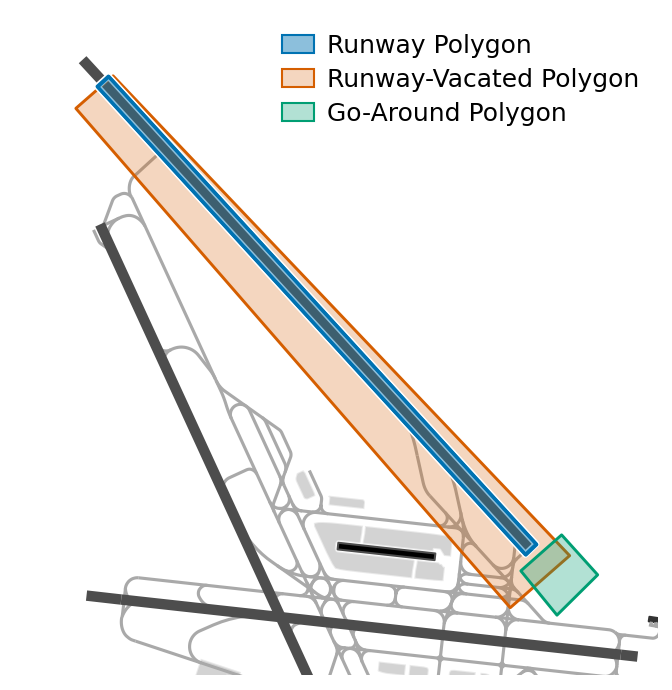

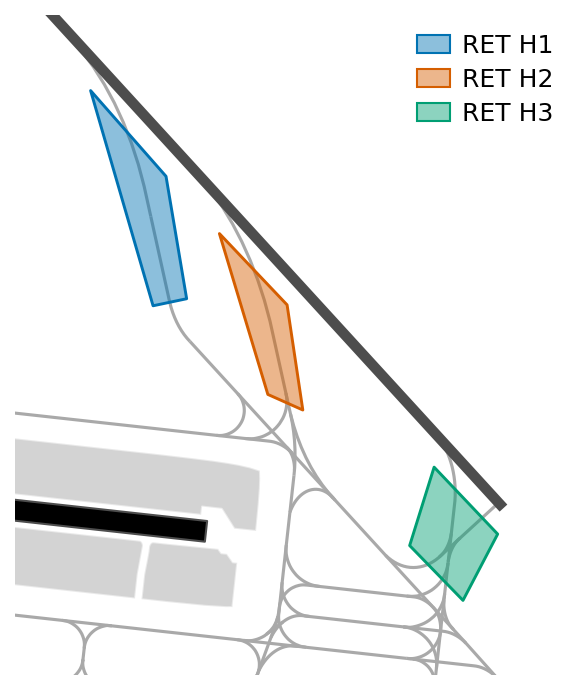

In [2]:
data_proj = ccrs.PlateCarree()

# ----------------------------
# Settings
# ----------------------------
PAD_M        = 300        # padding for fig 1
PAD_RETS     = 120        # tighter padding for fig 2 (zoom)
FIGSIZE_INCH = (4.4, 4.4) # identical for both
FONTSIZE     = 9
airport_str  = "LSZH"     # optional basemap

mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 600,
    "font.size": FONTSIZE,
    "axes.facecolor": "white",
    "axes.edgecolor": "none",
    "figure.constrained_layout.use": False,  # keep canvas size identical
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "patch.antialiased": True,
    "lines.antialiased": True,
})

# Ensure output folder
out_dir = "Plots"
os.makedirs(out_dir, exist_ok=True)

# ----------------------------
# Helpers
# ----------------------------
def latlon_to_lonlat(coords):
    return [(lon, lat) for (lat, lon) in coords]

def _collect_xy(geom: BaseGeometry):
    if geom.geom_type == "Polygon":
        xs, ys = geom.exterior.xy
        yield xs, ys
        for ring in geom.interiors:
            xs, ys = ring.xy
            yield xs, ys
    elif geom.geom_type.startswith("Multi"):
        for g in geom.geoms:
            yield from _collect_xy(g)
    else:
        xs, ys = geom.xy
        yield xs, ys

def extent_from_geoms(geoms, data_crs, map_crs, pad_m=0):
    Xs, Ys = [], []
    for g in geoms:
        for xs, ys in _collect_xy(g):
            pts = map_crs.transform_points(data_crs, np.asarray(xs), np.asarray(ys))
            Xs.append(pts[:, 0]); Ys.append(pts[:, 1])
    X = np.concatenate(Xs); Y = np.concatenate(Ys)
    return (X.min()-pad_m, X.max()+pad_m, Y.min()-pad_m, Y.max()+pad_m)

# ----------------------------
# Data (lat, lon)
# ----------------------------
runway_coordinates_14 = [
    (47.482343, 8.536430),
    (47.481882, 8.535696),
    (47.461058, 8.564121),
    (47.461527, 8.564832),
]
vacated_coordinates_14 = [
    (47.482383375839085, 8.536704667668287),
    (47.48091837115578,  8.53426271448043),
    (47.45869688991013,  8.563109678080252),
    (47.46104054317113,  8.567008077240228),
]
rwy_end_coordinates_14 = [
    (47.461967, 8.566471),
    (47.460347, 8.563795),
    (47.458375, 8.566194),
    (47.460188, 8.568865),
]

# RET polygons
H1_coordinates = [
    (47.466040, 8.557257),
    (47.467266, 8.555648),
    (47.464178, 8.556998),
    (47.464282, 8.557709),
]
H2_coordinates = [
    (47.464202, 8.559839),
    (47.465221, 8.558396),
    (47.462913, 8.559442),
    (47.462692, 8.560185),
]
H3_coordinates = [
    (47.460924, 8.564330),
    (47.461881, 8.562975),
    (47.460752, 8.562466),
    (47.459968, 8.563603),
]

# Polygons (lon, lat)
runway_polygon_14         = Polygon(latlon_to_lonlat(runway_coordinates_14))
runway_vacated_polygon_14 = Polygon(latlon_to_lonlat(vacated_coordinates_14))
runway_end_polygon_14     = Polygon(latlon_to_lonlat(rwy_end_coordinates_14))

H1_polygon = Polygon(latlon_to_lonlat(H1_coordinates))
H2_polygon = Polygon(latlon_to_lonlat(H2_coordinates))
H3_polygon = Polygon(latlon_to_lonlat(H3_coordinates))

# ----------------------------
# CRS & features
# ----------------------------
data_crs = ccrs.PlateCarree()
map_crs  = EuroPP()

feat_runway  = ShapelyFeature([runway_polygon_14],         crs=data_crs)
feat_vacated = ShapelyFeature([runway_vacated_polygon_14], crs=data_crs)
feat_rwy_end = ShapelyFeature([runway_end_polygon_14],     crs=data_crs)

feat_h1 = ShapelyFeature([H1_polygon], crs=data_crs)
feat_h2 = ShapelyFeature([H2_polygon], crs=data_crs)
feat_h3 = ShapelyFeature([H3_polygon], crs=data_crs)

# ----------------------------
# Colors
# ----------------------------
RUNWAY_EDGE, RUNWAY_FACE = "#0072B2", to_rgba("#0072B2", 0.45)
VAC_EDGE,    VAC_FACE    = "#D55E00", to_rgba("#D55E00", 0.25)
GO_EDGE,     GO_FACE     = "#009E73", to_rgba("#009E73", 0.30)

H1_EDGE, H1_FACE = "#0072B2", to_rgba("#0072B2", 0.45)
H2_EDGE, H2_FACE = "#D55E00", to_rgba("#D55E00", 0.45)
H3_EDGE, H3_FACE = "#009E73", to_rgba("#009E73", 0.45)

APRON_EDGE, APRON_FACE = "#b8bcc3", "#f5f6f8"

# ----------------------------
# Extents
# ----------------------------
# Fig 1: runway/vacated/go-around with PAD_M
EXTENT_WIDE = extent_from_geoms(
    [runway_polygon_14, runway_vacated_polygon_14, runway_end_polygon_14],
    data_crs, map_crs, pad_m=PAD_M
)
# Fig 2: RETs only with tighter padding
EXTENT_RETS = extent_from_geoms(
    [H1_polygon, H2_polygon, H3_polygon],
    data_crs, map_crs, pad_m=PAD_RETS
)

# =====================================================================
# FIGURE 1: Runway/Vacated/Go-Around (original width)
# =====================================================================
fig1, ax1 = plt.subplots(1, 1, figsize=FIGSIZE_INCH, subplot_kw=dict(projection=map_crs))
ax1.set_position([0, 0, 1, 1])  # axis fills the figure

# Optional basemap
if 'airports' in globals():
    airports[airport_str].plot(
        ax1, by='aeroway',
        aerodrome=dict(edgecolor=APRON_EDGE, facecolor=APRON_FACE, linewidth=0.5, alpha=1.0),
    )

xmin, xmax, ymin, ymax = EXTENT_WIDE
ax1.set_extent([xmin, xmax, ymin, ymax], crs=map_crs)

# Remove frame/ticks
try: ax1.spines.get("geo").set_visible(False)
except Exception: pass
ax1.set_frame_on(False)
ax1.set_xticks([]); ax1.set_yticks([])

# Draw
ax1.add_feature(feat_vacated, facecolor=VAC_FACE, edgecolor=VAC_EDGE, linewidth=1.4, zorder=5)
ax1.add_feature(feat_rwy_end, facecolor=GO_FACE,  edgecolor=GO_EDGE,  linewidth=1.4, zorder=6)
pe_white = [pe.Stroke(linewidth=3.2, foreground="white"), pe.Normal()]
ax1.add_feature(feat_runway, facecolor='none', edgecolor=RUNWAY_EDGE, linewidth=1.6,
                zorder=7, path_effects=pe_white)
ax1.add_feature(feat_runway, facecolor=RUNWAY_FACE, edgecolor=RUNWAY_EDGE, linewidth=1.6, zorder=8)

# Legend
handles1 = [
    Patch(facecolor=RUNWAY_FACE, edgecolor=RUNWAY_EDGE, label='Runway Polygon'),
    Patch(facecolor=VAC_FACE,    edgecolor=VAC_EDGE,    label='Runway-Vacated Polygon'),
    Patch(facecolor=GO_FACE,     edgecolor=GO_EDGE,     label='Go-Around Polygon'),
]
ax1.legend(handles=handles1, loc='upper right', frameon=True, framealpha=0,
           facecolor='white', edgecolor="#e0e0e0", borderpad=0.25,
           labelspacing=0.4, handlelength=1.3, handletextpad=0.5, fontsize=12)

# Save without tight bbox to keep identical canvas size
fig1.savefig(os.path.join(out_dir, "rwy14_polygons_clean.pdf"))

# =====================================================================
# FIGURE 2: RET H1/H2/H3 (zoomed)
# =====================================================================
fig2, ax2 = plt.subplots(1, 1, figsize=FIGSIZE_INCH, subplot_kw=dict(projection=map_crs))
ax2.set_position([0, 0, 1, 1])

if 'airports' in globals():
    airports[airport_str].plot(
        ax2, by='aeroway',
        aerodrome=dict(edgecolor=APRON_EDGE, facecolor=APRON_FACE, linewidth=0.5, alpha=1.0),
    )

xmin, xmax, ymin, ymax = EXTENT_RETS
ax2.set_extent([xmin, xmax, ymin, ymax], crs=map_crs)

try: ax2.spines.get("geo").set_visible(False)
except Exception: pass
ax2.set_frame_on(False)
ax2.set_xticks([]); ax2.set_yticks([])

ax2.add_feature(feat_h3, facecolor=H3_FACE, edgecolor=H3_EDGE, linewidth=1.4, zorder=6)
ax2.add_feature(feat_h2, facecolor=H2_FACE, edgecolor=H2_EDGE, linewidth=1.4, zorder=6)
ax2.add_feature(feat_h1, facecolor=H1_FACE, edgecolor=H1_EDGE, linewidth=1.4, zorder=6)

handles2 = [
    Patch(facecolor=H1_FACE, edgecolor=H1_EDGE, label='RET H1'),
    Patch(facecolor=H2_FACE, edgecolor=H2_EDGE, label='RET H2'),
    Patch(facecolor=H3_FACE, edgecolor=H3_EDGE, label='RET H3'),
]
ax2.legend(handles=handles2, loc='upper right', frameon=True, framealpha=0,
           facecolor='white', edgecolor="#e0e0e0", borderpad=0.25,
           labelspacing=0.4, handlelength=1.3, handletextpad=0.5, fontsize=12)

# Save without tight bbox
fig2.savefig(os.path.join(out_dir, "RET_Polygons.pdf"))

plt.show()
